In [1]:
import tensorflow as tf
from keras.datasets import cifar10
from keras.utils import to_categorical
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
batch_size = 20
gpu = True

In [3]:
def conv(x, filter_size=3, stride=2, num_filters=64, is_output=False, name="conv",
         init=tf.contrib.layers.xavier_initializer(), gpu=True):
    input_shape = x.get_shape().as_list()
    with tf.name_scope(name):
        W_shape = (filter_size, filter_size, input_shape[-1], num_filters)
        W = tf.get_variable(name + "-w", W_shape, initializer=init)
        strides = [1, stride, stride, 1]
        b = tf.get_variable(name + "-b", shape=num_filters, initializer=init)
        convolved = tf.nn.conv2d(x, W, strides, "SAME", gpu)
        output = tf.nn.bias_add(convolved, b)
        if is_output:
            return output
        return tf.nn.relu(output, name=name + "-relu")

In [4]:
def fc(x, out_size=50, is_output=False, name="fc", init=tf.contrib.layers.xavier_initializer(), gpu=True):
    batch_size, length = x.get_shape().as_list()
    with tf.name_scope(name):
        W_shape = (out_size, length)
        W = tf.get_variable(name + '-w', W_shape, initializer=init, dtype=tf.float32)
        b = tf.get_variable(name + '-b', out_size, initializer=tf.zeros_initializer(), dtype=tf.float32)
        multiplied = tf.matmul(W, tf.reshape(x, [-1, batch_size]))
        output = tf.reshape(multiplied, [-1, out_size])
        output = tf.nn.bias_add(output, b)
        return output if is_output else tf.nn.relu(output)

In [5]:
def flatten(x):
    in_shape = x.get_shape().as_list()
    flat_len = in_shape[1] * in_shape[2] * in_shape[3]
    target_shape = (in_shape[0], flat_len)
    return tf.reshape(x, target_shape)

In [6]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [7]:
with tf.device('/gpu:0'):
    data = tf.placeholder(tf.float32, (batch_size, 32, 32, 3), name='input')
    net = conv(data, num_filters=64, stride=2, name='conv1', gpu=gpu)
    net = conv(net, num_filters=64, stride=2, name='conv2', gpu=gpu)
    net = flatten(net)
    net = fc(net, out_size=256, name='fc1', gpu=gpu)
    net = fc(net, out_size=10, name='fc2', is_output=True, gpu=gpu)

    labels = tf.placeholder(tf.float32, (batch_size, 10), name='labels')
    with tf.name_scope("loss"):
        ce = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=net)
        loss = tf.reduce_mean(ce)

    with tf.name_scope('accuracy'):
        correct = tf.equal(tf.argmax(net,1), tf.argmax(labels,1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    train_step = tf.train.AdamOptimizer(.0001).minimize(loss)

In [8]:
writer = tf.summary.FileWriter("viz", sess.graph)
writer.close()

In [9]:
((x_train, y_train), (x_test, y_test)) = cifar10.load_data()

In [10]:
def prep_x(data):
    return data.astype('float32') / 255
def prep_y(labels):
    return to_categorical(labels)

In [11]:
x_train = prep_x(x_train)
x_test = prep_x(x_test)
y_train = prep_y(y_train)
y_test = prep_y(y_test)

In [12]:
sess.run(tf.global_variables_initializer())
x_train = x_train
y_train = y_train
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []
for e in range(20):
    x_train, y_train = shuffle(x_train, y_train)
    #train
    accuracies = []
    losses = []
    for i in range(int(len(x_train) / batch_size)):
        batch_x = x_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        _, loss_res, acc_res = sess.run([train_step, loss, accuracy], {data: batch_x, labels: batch_y})
        accuracies.append(acc_res)
        losses.append(loss_res)
        if (i * batch_size) % 100 == 0 and i > 0: # output every 100 images
            train_accuracies.append(sum(accuracies[:20])/20)
            train_losses.append(sum(losses[:20])/20)
#             print("Training Loss:", sum(losses)/len(losses), "Training Accuracy:", sum(accuracies)/len(accuracies))
        
    #validate
    val_acc_sum = 0
    val_loss_sum = 0
    for i in range(int(len(x_test) / batch_size)):
        batch_x = x_test[i:i+batch_size]
        batch_y = y_test[i:i+batch_size]
        loss_res, acc_res = sess.run([loss, accuracy], {data: batch_x, labels: batch_y})
        val_acc_sum += acc_res
        val_loss_sum += loss_res
    val_acc = val_acc_sum / int(len(x_test) / batch_size)
    val_loss = val_loss_sum / int(len(x_test) / batch_size)
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)
    print("Epoch", e, "Validation Loss:", val_loss, "Validation Accuracy:", val_acc)

Epoch 0 Validation Loss: 2.30342644739 Validation Accuracy: 0.100900002137
Epoch 1 Validation Loss: 2.22738877368 Validation Accuracy: 0.147100003086
Epoch 2 Validation Loss: 2.13317943215 Validation Accuracy: 0.202100004062
Epoch 3 Validation Loss: 2.11451983571 Validation Accuracy: 0.218800005049
Epoch 4 Validation Loss: 2.03833651614 Validation Accuracy: 0.251400005497
Epoch 5 Validation Loss: 1.99257000113 Validation Accuracy: 0.265700006112
Epoch 6 Validation Loss: 1.95477089715 Validation Accuracy: 0.272900006205
Epoch 7 Validation Loss: 1.90749452305 Validation Accuracy: 0.310900007293
Epoch 8 Validation Loss: 1.85771240616 Validation Accuracy: 0.326800006792
Epoch 9 Validation Loss: 1.84530338168 Validation Accuracy: 0.330600007772
Epoch 10 Validation Loss: 1.77036895657 Validation Accuracy: 0.350000007451
Epoch 11 Validation Loss: 1.8002328918 Validation Accuracy: 0.335400007084
Epoch 12 Validation Loss: 1.74760322404 Validation Accuracy: 0.34780000633
Epoch 13 Validation Loss

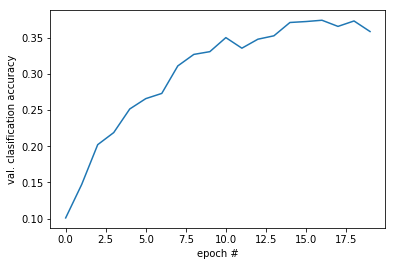

In [20]:
plt.plot(val_accuracies)
plt.xlabel("epoch #")
plt.ylabel("val. clasification accuracy")
plt.show()

![](https://preview.ibb.co/gq5OmG/graph.png)